In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['yelp-review-polarity']


In [9]:
from fastai.text import *


In [57]:
train = pd.read_csv('../input/yelp-review-polarity/yelp_review_polarity_csv/train.csv')
test = pd.read_csv('../input/yelp-review-polarity/yelp_review_polarity_csv/test.csv')
train = train.head(100000)

In [58]:
#adding column names
train.columns =['label', 'Phrase'] 
test.columns =['label', 'Phrase'] 

In [12]:
train.shape

(100000, 2)

In [13]:
train.head()


,label,Phrase
0,2,Been going to Dr. Goldberg for over 10 years. ...
1,1,I don't know what Dr. Goldberg was like before...
2,1,I'm writing this review to give you a heads up...
3,2,All the food is great here. But the best thing...
4,1,Wing sauce is like water. Pretty much a lot of...


In [14]:
test.head()

,label,Phrase
0,1,Last summer I had an appointment to get new ti...
1,2,"Friendly staff, same starbucks fair you get an..."
2,1,The food is good. Unfortunately the service is...
3,2,Even when we didn't have a car Filene's Baseme...
4,2,"Picture Billy Joel's \""Piano Man\"" DOUBLED mix..."


In [15]:
train['label'].unique()

array([2, 1])

In [16]:
data = (TextList.from_df(train, cols='Phrase')
                .split_by_rand_pct(0.2)
                .label_for_lm()  
                .databunch(bs=16))
data.show_batch()


idx,text
0,"the co - pay and having you come in for medication refills every month . xxmaj he will not give refills and could less about patients 's financial situations . xxmaj trying to get your 90 days mail away pharmacy prescriptions through this guy is a joke . xxmaj and to make matters even worse , his office staff is incompetent . 90 % of the time when you call"
1,"xxunk of chow mein . xxmaj on the xxmaj west coast ( where i was raised ) , chow mein refers to the steamed soft noodles and "" xxmaj hong xxmaj kong style "" refers to the crispy style fired noodles . xxmaj however , here on the xxmaj east coast , "" chow mein "" is assumed to be the crispy xxmaj hong xxmaj kong style , while """
2,"that it mattered because there were no xxunk ) . xxmaj the hostess then said she would come find us and knew where we were currently seated , only to never be seen or heard from again . xxmaj the unapologetic attitude , the unwillingness to make xxunk for an obvious oversight and error on the staff 's part , and the poor food quality have me hoping this place"
3,". \n \n xxmaj after going , i think perhaps we should find a new place . \n \n xxmaj the restaurant still looks the same and the ambiance is fine , but the food is tired and boring . \n \n xxmaj for the price you are paying , you 'd expect really good food , but instead it was all just kind of blah ."
4,get me started on the security and x - ray stations . i got to experience the awesome new airport in xxmaj singapore and thinking about while in line at xxmaj terminal 4 at xxmaj sky xxmaj harbor almost makes me cry every time . \n \n xxmaj where this terminal is the best is in the choice of food and drinks . xxmaj this is where xxmaj terminal


In [17]:
learn = language_model_learner(data,AWD_LSTM, drop_mult=0.3)


In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


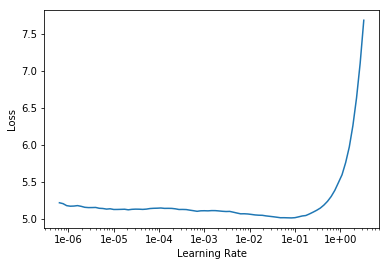

In [19]:
learn.recorder.plot()

In [20]:
#learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,4.092629,3.969171,0.280060,16:11


In [21]:
 # Tune a little more
learn.unfreeze()
#learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,3.758003,3.659743,0.316738,18:23


In [22]:
learn.save_encoder('fine_tuned_enc')

In [23]:
test_datalist = TextList.from_df(test, cols='Phrase', vocab=data.vocab)

data_clas = (TextList.from_df(train, cols='Phrase', vocab=data.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df(cols= 'label')
             .add_test(test_datalist)
             .databunch(bs=16))

data_clas.show_batch()

text,target
"xxbos a xxup note xxup to xxup the xxup owner : \n xxmaj your employee , the scrawny , balding man , should be fired . \n xxmaj he was yelling at me and saying extremely rude things instead of fixing the nails to make the customer happy . i 've never been treated this way by any company that i 've ever done business with . i",1
xxbos xxmaj you xxmaj know xxmaj you 're xxmaj in xxmaj arizona xxmaj when xxrep 4 . \n \n \n \n xxmaj you think xxmaj taco xxmaj bell is the local phone company . \n \n xxmaj you notice your car overheating before you drive it . \n \n xxmaj you no longer associate bridges or rivers with water . \n \n xxmaj you can hear,2
"xxbos xxmaj the low overall rating , in my opinion , is a totally inaccurate summary of the xxup jcc . xxmaj they provide a xxup ton of different services - having to swipe your card twice at the door or finding a broken treadmill should not be the basis for a bad review of a large organization that provides childcare , gym space , cultural activities , classes ,",2
"xxbos i went this weekend for a bachelor party . xxmaj we bought the $ xxunk deal with a limo ride and a $ 40 bar tab . \n \n xxmaj the limo was a bit dirty with a broken sunroof , whatever . xxmaj we tipped the dude $ 10 for a 5 minute ride . xxmaj he said call him with a half hour notice for a",1
"xxbos xxup yuck ! \n xxmaj just xxmaj yuck . \n \n xxmaj they have a large selection of coffee drinks you can get on their menu , each one i 've tried was more unappetizing than the last . \n xxmaj on my first visit i opted for an iced toddy , my poison of choice . i watched the girl in the drive - thru",1


In [24]:
learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_classifier.load_encoder('fine_tuned_enc')
learn_classifier.freeze()


In [25]:
learn_classifier.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


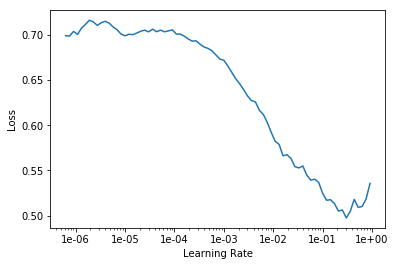

In [26]:
learn_classifier.recorder.plot()

In [27]:
#learn_classifier.fit_one_cycle(5, 2e-2, moms=(0.8,0.7))
learn_classifier.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.245394,0.167663,0.936450,08:21


In [28]:
learn_classifier.freeze_to(-2)
#learn_classifier.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn_classifier.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.254441,0.140030,0.946300,09:20


In [29]:
learn_classifier.freeze_to(-3)
#learn_classifier.fit_one_cycle(5, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn_classifier.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.151348,0.109073,0.958750,12:43


In [30]:
learn_classifier.show_results()


text,target,prediction
"xxbos xxmaj wow , this place is a xxup complete xxup scam & please do n't waste your time here . xxmaj talk about xxup substandard xxup service & a xxup business xxup who xxup only xxup cares xxup about xxup collecting xxup money ! i rarely even leave reviews but my experience was xxup so xxup awful & xxup unprofessional with such xxup horrible & xxup unprofessional service i",1,1
xxbos i am a senior graduating with a xxup bs in xxmaj math and another in xxmaj electrical xxmaj engineering and am in xxmaj barrett xxmaj honors xxmaj college . xxmaj with over a 4.0 . i can tell you that xxup asu has been the biggest sh*thole waste of 3 1 / 2 years of my life ( i did 2 years at community college ... and a year,1,1
"xxbos i mean , it 's not that this place is a bad gym , its just xxrep 4 . \n \n i 'm a member here , but i wo n't leave even though this place does kinda suck , almost in an endearing way . xxmaj like they ( xxup la xxmaj fitness ) are totally fine in some xxunk they have a decent array of equipment",1,1
xxbos xxup part xxup one : xxmaj as of now i will say i give it two stars this is a on going review so have a seat . xxmaj this is gon na take a while ! \n i went in store last xxmaj thursday with the husband . xxmaj he asks to see home movie chairs the staff member told us his name is xxmaj danny and,1,1
xxbos xxmaj closest to home and xxup last xxup choice when i need to shop walmart -- i xxup will go xxup out xxup of xxup my xxup way to avoid this store whenever i possibly can and you should too ! \n \n xxmaj this store is on the center of a middle / upper - middle class area and it 's run as if it 's in,1,1


In [31]:
preds, target = learn_classifier.get_preds(DatasetType.Test, ordered=True)
labels = np.argmax(preds, axis =1)


In [32]:
labels = np.argmax(preds, axis =1).double()

In [33]:
submission = pd.DataFrame({ 'label': labels})
submission.to_csv('submission1.csv', index=False)
submission.head()

,label
0,0.0
1,1.0
2,0.0
3,1.0
4,1.0


In [34]:
submission.shape

(37999, 1)

In [35]:
!pip install -U nltk

     |████████████████████████████████| 1.4MB 3.0MB/s eta 0:00:01
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built nltk
ERROR: allennlp 0.8.4 requires awscli>=1.11.91, which is not installed.
ERROR: allennlp 0.8.4 requires flaky, which is not installed.
ERROR: allennlp 0.8.4 requires responses>=0.7, which is not installed.
ERROR: preprocessing 0.1.13 has requirement nltk==3.2.4, but you'll have nltk 3.5 which is incompatible.
  Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4


In [38]:
test.head()

,label,Phrase
0,1,Last summer I had an appointment to get new ti...
1,2,"Friendly staff, same starbucks fair you get an..."
2,1,The food is good. Unfortunately the service is...
3,2,Even when we didn't have a car Filene's Baseme...
4,2,"Picture Billy Joel's \""Piano Man\"" DOUBLED mix..."


In [44]:
test_y = labels.numpy().astype(int)+1

In [67]:
test = test.label.values.astype(int)

In [64]:
test_y

array([1, 2, 1, 2, ..., 2, 1, 1, 1])

In [65]:
from sklearn.metrics import accuracy_score

In [68]:
print(accuracy_score(test,test_y))

0.9577620463696414


In [69]:
!git clone https://github.com/jasonwei20/eda_nlp.git

Cloning into 'eda_nlp'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 393 (delta 4), reused 10 (delta 4), pack-reused 379
Receiving objects: 100% (393/393), 20.41 MiB | 14.37 MiB/s, done.
Resolving deltas: 100% (187/187), done.


In [ ]:
./eda_nlp

In [70]:
!python ./eda_nlp/code/augment.py --input=<test.csv>

/bin/sh: 1: Syntax error: end of file unexpected
